In [1]:
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
import psycopg2

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

#this line causes errors when running as a .py script
get_ipython().magic(u'matplotlib inline')
matplotlib.style.use('ggplot')
pd.options.display.max_rows = 40
#pd.options.display.max_colwidth = 200
pd.options.display.show_dimensions = True

def connect():
    #parameter format for local use
    params = {
    'dbname':'hmda',
    'user':'roellk',
    'password':'',
    'host':'localhost',}
    #connect_string = "dbname=%s user=%s host=%s password =%s" %(dbname, user, host, password) #set a string for connection to SQL
    try:
        conn = psycopg2.connect(**params)
        print("i'm connected")
        #return conn.cursor(cursor_factory=psycopg2.extras.DictCursor) #return a dictionary cursor object
        return conn.cursor()
    except psycopg2.Error as e: #if database connection results in an error print the following
        print("I am unable to connect to the database: ", e)

def line_graph(field_df, title=None, size=(20,10), ylim=None, x=np.arange(2004,2017)):
    """size is a tuple of width x height, ylim is a tuple of min x max"""
    plt.figure(figsize=size)
    color_list = ["purple", "blue", "orange", "yellow", "green", "grey", "black", "white", "red"]
    field_list = list(field_df.columns.ravel())
    patch_list = []
#    w_patch = mpatches.Patch(color="green", label="white")
    for field in field_list:
        color_index = field_list.index(field)
        plt.plot(x, field_df[field], color=color_list[color_index]) 
        field_patch = mpatches.Patch(color=color_list[color_index], label=field)
        patch_list.append(field_patch)
    if ylim:
        plt.ylim=ylim
    plt.legend(handles=patch_list)
    plt.title(title)

        
def tabular_lines(y_dict, title=None, size=(20,10), ylim=None, x=np.arange(2004,2017)):
    plt.figure(figsize=size)
    color_list = ["purple", "blue", "orange", "yellow", "green", "grey", "black", "white", "red"]
    if ylim:
        plt.ylim = ylim
    patch_list = []
    y_list = list(y_dict.keys())
    for field in y_list:
        color_index = y_list.index(field)
        plt.plot(x, y_dict[field], color=color_list[color_index])
        field_patch = mpatches.Patch(color=color_list[color_index], label=field)
        patch_list.append(field_patch)
    plt.legend(handles=patch_list)
    plt.title(title)

In [2]:
#this code will examine the incidence of higher cost loans on manufactured housing in historic HMDA LAR data.
#Higher cost loans for manufactured housing are defined as:
#A first lien on a loan with >=50K principal with a rate spread of 6.5% or more
#A first lien on a loan with <50K principal with a rate spread of 8.5% or more
#A junior lien with a rate spread of 8.5% or more
#Note: high cost loans are only covered by HOEPA if on a principle residence
#Note: rate spread in HMDA has had different benchmarks
# - rate spread prior to 2010 was calculated using treasury 10 year notes
# - rate spread 2010 and later is calculated using APOR tables 
#Note: the change was made in 4q 2009, so 2009 uses mixed data in rate spread calculations and is often
#excluded from analysis
#Note: rate spread analysis is commonly done only on originations

In [56]:
sql = """SELECT
    year
	,(CASE WHEN rate_spread LIKE '%NA%' OR rate_spread LIKE '%na%' OR rate_spread LIKE '% %' 
    THEN 'NaN' ELSE rate_spread END) AS rate_spread
	,lien_status
	,loan_amount
	,loan_purpose
    ,hoepa
    ,CONCAT(state_code, county_code) AS county_fips

FROM {table}
WHERE action_type = '1' AND property_type = '2' AND occupancy = '1' AND loan_purpose IN ('1', '3')
ORDER BY rate_spread DESC"""

#list of public HMDA data tables in PG
lar_tables = ["lar_2004_ffiec", "lar_2005_ffiec", "lar_2006_ffiec", "lar_2007_ffiec", "lar_2008_ffiec", "lar_2009_ffiec"
         ,"lar_2010_ffiec", "lar_2011_ffiec", "lar_2012_ffiec", "lar_2013_ffiec", "lar_2014_ffiec", "lar_2015_ffiec",
         "lar_2016_ffiec"]

In [57]:
#Connect to database and pull data
cur = connect()
first = True
for table in lar_tables:
    sql_rs = sql.format(table=table)
    cur.execute(sql_rs)
    colnames = [desc[0] for desc in cur.description]
    results_df = pd.DataFrame(cur.fetchall(), columns=colnames)

    if first:
        rs_df = results_df.copy()
        first = False
    else:
        rs_df = pd.concat([rs_df, results_df], axis=0)
    print(rs_df.tail())
        
rs_df.head()


i'm connected
        year rate_spread lien_status loan_amount loan_purpose hoepa  \
219239  2004       03.00           1       00024            1     2   
219240  2004       03.00           1       00033            3     2   
219241  2004       03.00           1       00032            3     2   
219242  2004       03.00           1       00028            1     2   
219243  2004       03.00           1       00057            1     2   

       county_fips  
219239       05119  
219240       25013  
219241       12081  
219242       20107  
219243       55079  

[5 rows x 7 columns]
        year rate_spread lien_status loan_amount loan_purpose hoepa  \
210341  2005       03.00           1       00150            1     2   
210342  2005       03.00           1       00023            1     2   
210343  2005       03.00           1       00024            3     2   
210344  2005       03.00           1       00024            1     2   
210345  2005       03.00           1       00018        

,year,rate_spread,lien_status,loan_amount,loan_purpose,hoepa,county_fips
0,2004,NaN,1,00005,1,2,01003
1,2004,NaN,1,00072,1,2,NANA
2,2004,NaN,1,00050,1,2,39029
3,2004,NaN,1,00048,1,2,29209
4,2004,NaN,1,00009,3,2,39029


In [26]:
#change data types for mathematics
rs_df.loan_amount = rs_df.loan_amount.apply(lambda x: int(x))
rs_df.rate_spread = rs_df.rate_spread.apply(lambda x: float(x))
#set high priced flag for rate spreads that meet conditions
def is_high_priced(row):
    if row['lien_status']=='1' and row['loan_amount'] >=50 and row['rate_spread'] >= 6.5:
        return 1
    elif row['lien_status']=='1' and row['loan_amount'] <50 and row['rate_spread']>=8.5:
        return 1
    elif row['lien_status']=='2' and row['rate_spread']>=8.5:
        return 1
    else:
        return 0
    
rs_df['high_priced'] = rs_df.apply(is_high_priced, axis=1)


In [55]:
#get amount summed by year for high priced and normal loans
#multi index set for high priced flag and year
def calc_rs_stats(rs_df):
    amount_df = rs_df[['year', 'high_priced', 'loan_amount']].groupby(['high_priced', 'year']).sum().copy()
    total_high_rows = rs_df[rs_df.high_priced==1].groupby('year').count().copy()
    total_rows = rs_df.groupby('year').count().copy()
    analysis_df = total_high_rows / total_rows
    analysis_df = analysis_df[['hoepa']]
    analysis_df.columns = ['high_priced_pct']
    analysis_df['count_high'] = total_high_rows['rate_spread']
    analysis_df['count_total'] = rs_df[['year','rate_spread']].groupby('year').count()
    analysis_df['count_normal'] = analysis_df['count_total'] - analysis_df['count_high']
    analysis_df['percent_normal'] = 1 - analysis_df['high_priced_pct']
    analysis_df['amount_high'] = amount_df['loan_amount'].loc[1]
    analysis_df['amount_normal'] = amount_df['loan_amount'].loc[0]
    analysis_df['amount_total'] = analysis_df['amount_high'] + analysis_df['amount_normal']
    analysis_df['amount_high_pct'] = analysis_df.apply(lambda x: x.amount_high/x.amount_total, axis=1)
    analysis_df['amount_normal_pct'] = analysis_df.apply(lambda x: x.amount_normal/x.amount_total, axis=1)
    return analysis_df
#home purchase loans <=50k
purch_less_50 = calc_rs_stats(rs_df[(rs_df.loan_purpose=='1')&(rs_df.loan_amount<50)])
purch_over_50 = calc_rs_stats(rs_df[(rs_df.loan_purpose=='1')&(rs_df.loan_amount>=50)])
#no refinances present
#refi_less_50 = calc_rs_stats(rs_df[(rs_df.loan_purpose=='3')&(rs_df.loan_amount<50)])
refi_over_50 = calc_rs_stats(rs_df[(rs_df.loan_purpose=='3')&(rs_df.loan_amount>=50)])
lien_1 = calc_rs_stats(rs_df[(rs_df.lien_status=='1')&(rs_df.loan_amount<50)])
lien_2 = calc_rs_stats(rs_df[(rs_df.lien_status=='1')&(rs_df.loan_amount>=50)])
all_less_50 = calc_rs_stats(rs_df[(rs_df.loan_amount<50)])
all_over_50 = calc_rs_stats(rs_df[(rs_df.loan_amount>=50)])
#total incidence trend as percent
#total incidence raw counts
#trend for over 50k and under 50k separately (percents and counts)
#analysis by purpose?
#analysis by lien status
#baseline against trend in single family homes?
#by geography
all_high = calc_rs_stats(rs_df)


KeyError: 'the label [1] is not in the [index]'

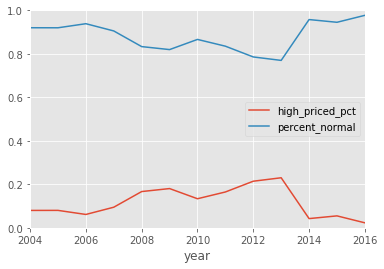

In [44]:
analysis_df[['high_priced_pct', 'percent_normal']].plot(ylim=(0,1))

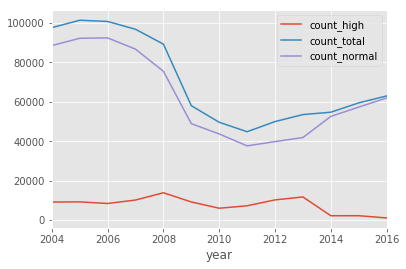

In [29]:
percent_high[['count_high', 'count_total', 'count_normal']].plot()

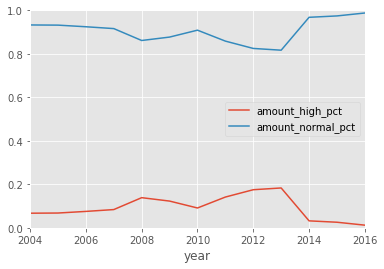

In [30]:
percent_high[['amount_high_pct', 'amount_normal_pct']].plot(ylim=(0,1))

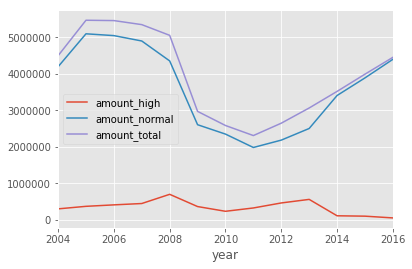

In [31]:
percent_high[['amount_high', 'amount_normal', 'amount_total']].plot()

In [52]:

amount_df = rs_df[(rs_df.loan_purpose=='3')&(rs_df.loan_amount>=50)][['year', 'high_priced', 'loan_amount']].groupby(['high_priced', 'year']).sum().copy()
amount_df

,,loan_amount
high_priced,year,


In [53]:
rs_df[(rs_df.loan_purpose=='3')]

,year,rate_spread,lien_status,loan_amount,loan_purpose,hoepa,high_priced
